Authors: Antoine A. Ruzette
Date: 2025-02-21

This notebook processes cell measurement tables exported from QuPath to plot the spatial distribution of cell-level pixel intensity in relation to a modelled stromal border. It also supports the comparison of confusion matrices between threshold- and machine learning-based cell classification.

Contains the code to plot data from images containing four channels: DAPI (nuclei), FITC (cytokeratin), TRITC (fibronectin) and CY5 (Ki67). 

In [1]:
import os
import pandas as pd
import numpy as np
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import natsort
import re
from matplotlib.ticker import LogFormatterSciNotation
from fitter import Fitter, get_common_distributions, get_distributions

# colorblind-friendly colors
CB_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']

## Back-end functions

In [2]:
def load_and_preprocess_files(folder_path, file_paths, expected_columns):
    """
    Load and preprocess CSV files.

    Args:
        folder_path (str): Path to the folder containing CSV files.
        file_paths (list): List of file names.
        expected_columns (dict): Dictionary mapping expected column keys to possible names.

    Returns:
        list: A list of processed DataFrames (one per image).
        dict: Column mapping for use in plotting.
    """
    dfs = []
    final_column_mapping = {}

    for image in file_paths:
        print(f"\n🔹 Processing: {image}")
        file_path = os.path.join(folder_path, image)

        # Load CSV to check available columns first
        try:
            df_sample = pd.read_csv(file_path, nrows=1)
            available_columns = df_sample.columns.tolist()
            print(f"✅ Available Columns: {available_columns}")
        except Exception as e:
            print(f"❌ Error loading {image}: {e}")
            continue

        # Dynamically map expected column names to available ones
        column_mapping = {}
        for key, possible_names in expected_columns.items():
            for name in possible_names:
                if name in available_columns:
                    column_mapping[key] = name
                    break
            else:
                print(f"⚠️ Warning: {key} column not found in {image}. Skipping.")

        if not column_mapping:
            print(f"⚠️ Skipping {image} as no expected columns were found.")
            continue

        # Reload dataframe with only found columns
        try:
            df = pd.read_csv(file_path, usecols=list(column_mapping.values()))
        except Exception as e:
            print(f"❌ Error loading selected columns in {image}: {e}")
            continue

        # Skip this file if essential columns are missing
        essential_columns = ["DAPI", "pNDRG1_647"]
        missing_essential = [col for col in essential_columns if col not in column_mapping]
        if missing_essential:
            print(f"⚠️ Skipping {image} due to missing essential columns: {missing_essential}")
            continue

        # Remove outliers dynamically (only for present columns)
        outlier_limits = {}
        for key in ["DAPI", "pNDRG1_647", "KER_488", "FN_568"]:
            if key in column_mapping:
                col_name = column_mapping[key]
                p01 = df[col_name].quantile(0.01)
                p99 = df[col_name].quantile(0.99)
                outlier_limits[col_name] = (p01, p99)

        print(f"📊 Outlier Thresholds: {outlier_limits}")

        # Filter outliers
        df_no_outlier = df.copy()
        for col, (p01, p99) in outlier_limits.items():
            df_no_outlier = df_no_outlier[(df_no_outlier[col] >= p01) & (df_no_outlier[col] <= p99)]

        if df_no_outlier.empty:
            print(f"⚠️ Skipping {image} as it became empty after outlier removal.")
            continue

        # ✅ Store actual filename instead of "1G", "2G" etc.
        df_no_outlier["Image"] = os.path.splitext(os.path.basename(image))[0]

        dfs.append(df_no_outlier)

        # Save column mapping for later use
        final_column_mapping = column_mapping  

    if dfs:
        return dfs, final_column_mapping
    else:
        print("⚠️ No valid data loaded.")
        return [], {}


# Helper function to generate floating point ranges
def frange(start, stop, step):
    """Generate a range of floats with a given step size."""
    while start <= stop:
        yield start
        start += step


# Cell measurement distributions for each channel

## Linear scale distributions


🔹 Processing: 20252803_AsPC LZ #1 GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv
✅ Available Columns: ['Image', 'Class', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'KER_488: Nucleus: Mean', 'KER_488: Nucleus: Median', 'KER_488: Nucleus: Min', 'K

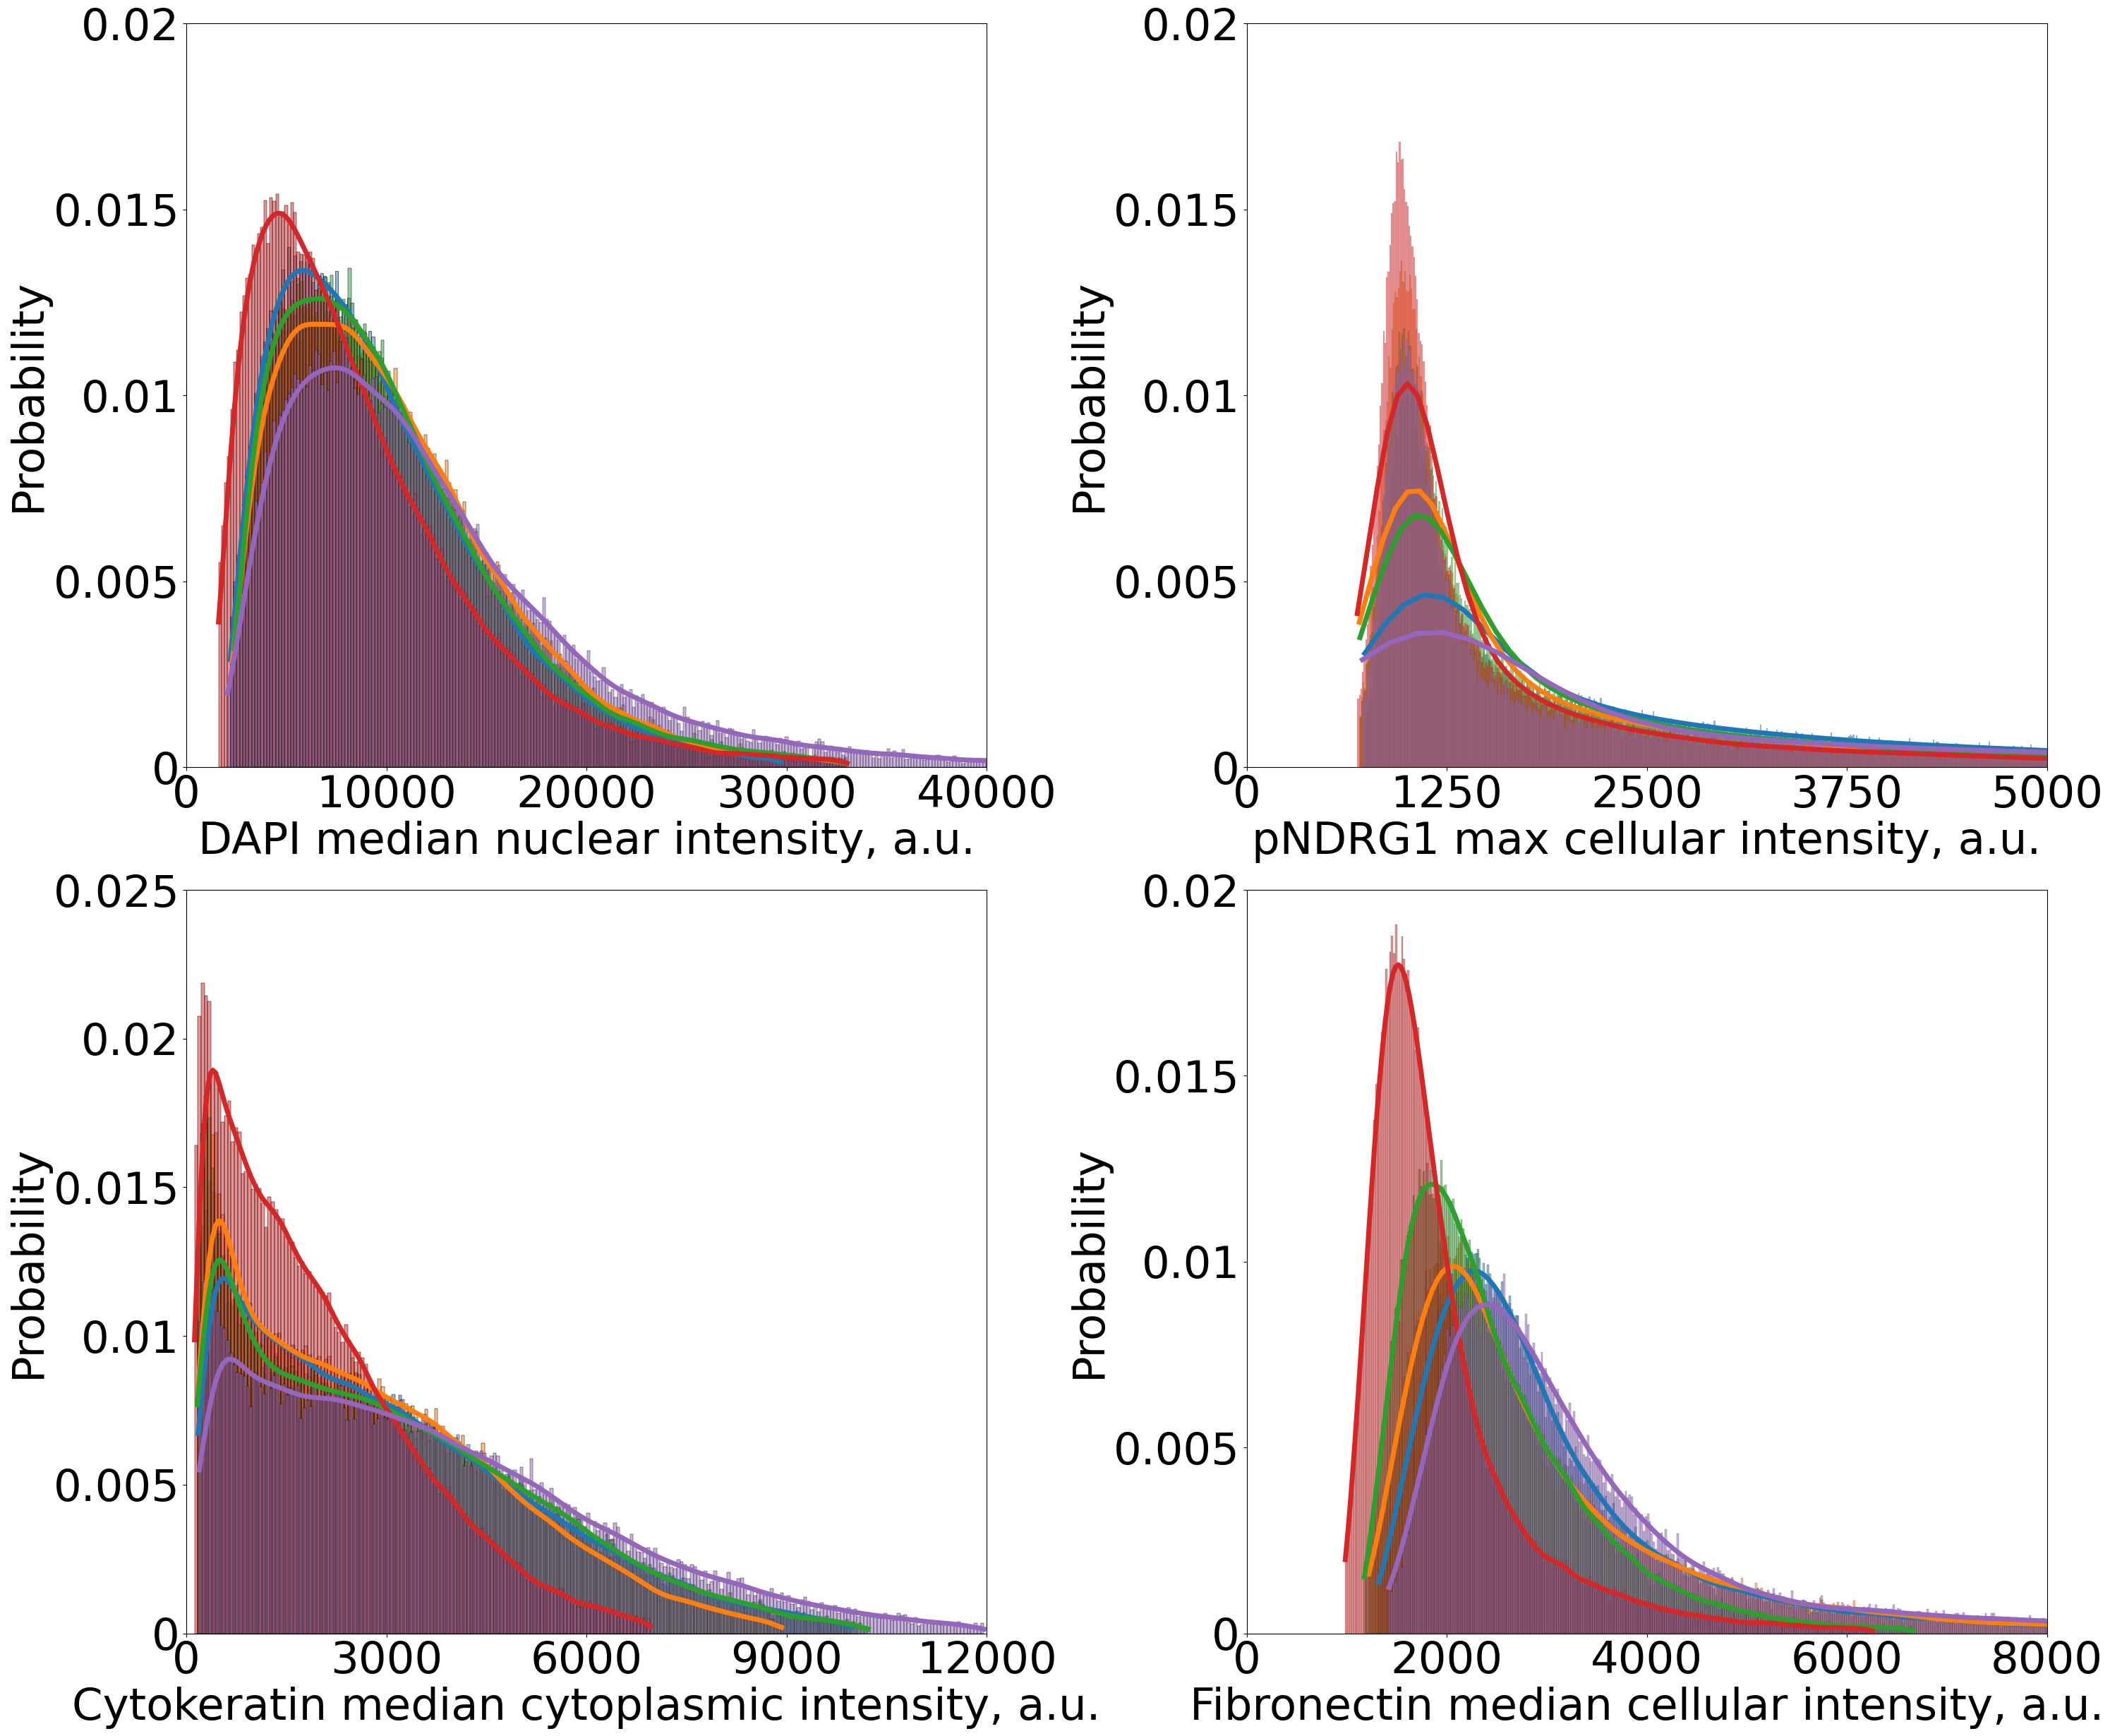

In [8]:
# Define folder and file paths
folder_path = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_NDRG1/results/histograms"

file_paths = [
    "20252803_AsPC LZ #1 GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv",
    "20252803_AsPC LZ #2 GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv",
    "20252803_AsPC LZ #3 GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv",
    "20252803_AsPC LZ #4 GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv",
    "20252803_AsPC LZ #5 GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv",
]

# Convert file paths to base names (without extensions) to ensure correct mapping
# file_base_names = [os.path.splitext(os.path.basename(f))[0] for f in file_paths]

# Define unique colors for each image
# color_palette = sns.color_palette("husl", len(file_paths))
# image_colors = {base_name: color for base_name, color in zip(file_base_names, color_palette)}

# Define bin sizes for each channel
bin_sizes = {
    "DAPI": 150,
    "pNDRG1_647": 10,
    "KER_488": 50,
    "FN_568": 20
}

expected_columns = {
    "Class": ["Class"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["KER_488: Cytoplasm: Median"],
    "pNDRG1_647": ["pNDRG1_647: Cell: Max"],
    "FN_568": ["FN_568: Cell: Median"]
    }

y_ticks = {
    "DAPI": [0, 0.005, 0.01, 0.015, 0.02],
    "pNDRG1_647": [0, 0.005, 0.01, 0.015, 0.02],
    "KER_488": [0, 0.005, 0.01, 0.015, 0.02, 0.025],
    "FN_568": [0, 0.005, 0.01, 0.015, 0.02]
}

# Load and preprocess data
dfs_data_list, column_mapping = load_and_preprocess_files(folder_path, file_paths, expected_columns)

# Ensure data is available before plotting
if dfs_data_list:
    fig, axs = plt.subplots(2, 2, figsize=(30, 26))

    plot_keys = ["DAPI", "pNDRG1_647", "KER_488", "FN_568"]
    axes_positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
    axis_limits = {
        "DAPI": (0, 40000),
        "pNDRG1_647": (0, 5000),
        "KER_488": (0, 12000),
        "FN_568": (0, 8000)
    }

    # Descriptive labels for axes
    axis_labels = {
        "DAPI": "DAPI median nuclear intensity, a.u.",
        "pNDRG1_647": "pNDRG1 max cellular intensity, a.u.",
        "KER_488": "Cytokeratin median cytoplasmic intensity, a.u.",
        "FN_568": "Fibronectin median cellular intensity, a.u."
    }

    plotted_something = False

    for df in dfs_data_list:
        image_label = df["Image"].iloc[0]
        # image_color = image_colors.get(image_label, "gray")

        for key, (row, col) in zip(plot_keys, axes_positions):
            if key in column_mapping and column_mapping[key] in df.columns:
                sns.histplot(
                    df[column_mapping[key]],
                    binwidth=bin_sizes.get(key, 10),  
                    kde=True,
                    line_kws={"linewidth": 5},
                    ax=axs[row, col],
                    label=image_label,
                    alpha=0.5,
                    # color=image_color,  
                    stat="probability"  
                )
                plotted_something = True

    # Set log scale, font sizes, tick sizes, and format plots
    for (key, (row, col)) in zip(plot_keys, axes_positions):
        ax = axs[row, col]
        ax.set_yscale('linear')
        ax.set_xscale('linear')
        ax.set_ylabel('Probability', fontsize=45)
        ax.set_xlabel(axis_labels[key], fontsize=45)
        ax.tick_params(axis='both', labelsize=45)

        # Limit x-axis range and set 5 ticks
        if key in axis_limits:
            ax.set_xlim(axis_limits[key])
            xticks = [axis_limits[key][0] + i * (axis_limits[key][1] - axis_limits[key][0]) / 4 for i in range(5)]
            ax.set_xticks(xticks)

        # Set specific y-ticks if defined
        if key in y_ticks:
            ax.set_yticks(y_ticks[key])
            ax.set_ylim(bottom=min(y_ticks[key]), top=max(y_ticks[key]))

        # Format y-tick labels nicely
        ax.set_yticklabels([f"{tick:.2g}" for tick in ax.get_yticks()])


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_NDRG1/plots/histograms/2025_measurements_distribution_pNDRG1.png", dpi=300)
    plt.show()
else:
    print("⚠️ No plots generated due to lack of valid data.")



🔹 Processing: 20252803_AsPC LZ #1 GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv
✅ Available Columns: ['Image', 'Class', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'KER_488: Nucleus: Mean', 'KER_488: Nucleus: Median', 'KER_488: Nucleus: Min', 'K

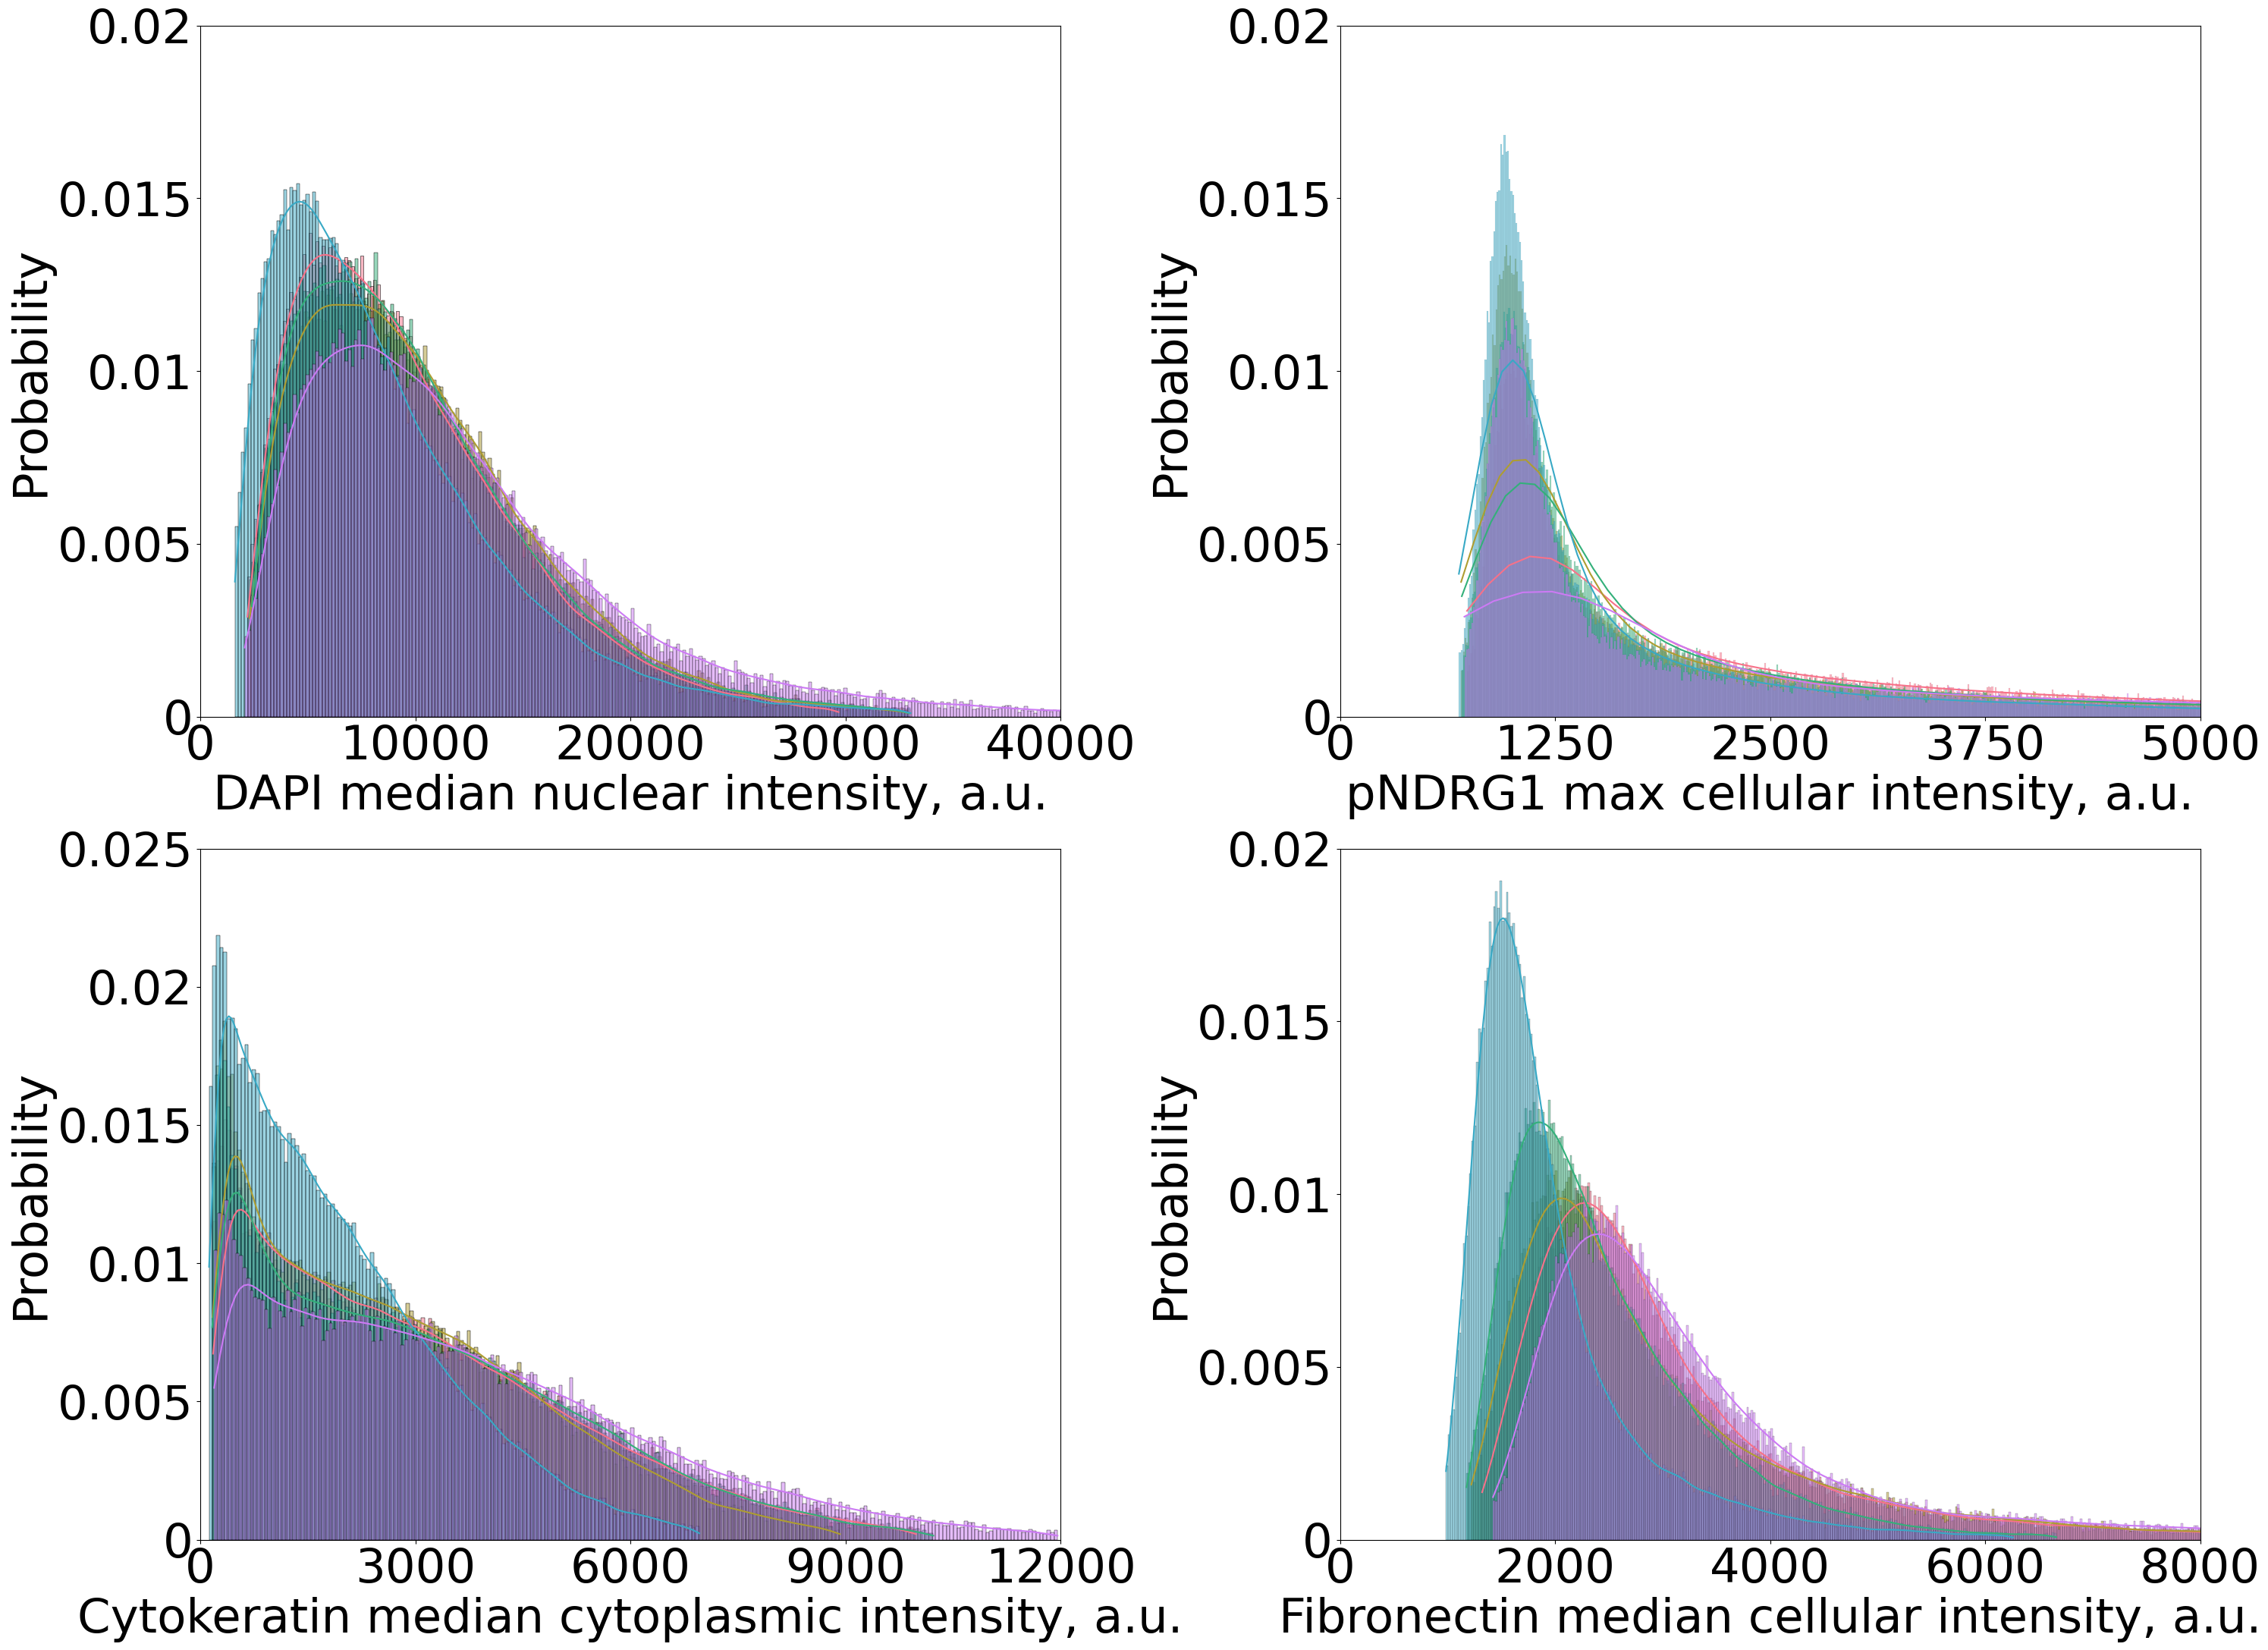

In [15]:
# Define folder and file paths
folder_path = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_NDRG1/results/histograms"

file_paths = [
    "20252803_AsPC LZ #1 GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv",
    "20252803_AsPC LZ #2 GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv",
    "20252803_AsPC LZ #3 GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv",
    "20252803_AsPC LZ #4 GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv",
    "20252803_AsPC LZ #5 GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv",
]

# Convert file paths to base names (without extensions) for color mapping
file_base_names = [os.path.splitext(os.path.basename(f))[0] for f in file_paths]

# Define unique colors for each image
color_palette = sns.color_palette("husl", len(file_paths))
image_colors = {base_name: color for base_name, color in zip(file_base_names, color_palette)}

# Define bin sizes for each channel
bin_sizes = {
    "DAPI": 150,
    "pNDRG1_647": 10,
    "KER_488": 50,
    "FN_568": 20
}

expected_columns = {
    "Class": ["Class"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["KER_488: Cytoplasm: Median"],
    "pNDRG1_647": ["pNDRG1_647: Cell: Max"],
    "FN_568": ["FN_568: Cell: Median"]
    }

# Manually define y-axis tick ranges and step sizes
y_axis_ticks = {
    "DAPI": (0, 0.02, 0.005),  # (start, stop, step)
    "pNDRG1_647": (0, 0.02, 0.005),
    "KER_488": (0, 0.025, 0.005),
    "FN_568": (0, 0.02, 0.005)
}

# Load and preprocess data
dfs_data_list, column_mapping = load_and_preprocess_files(folder_path, file_paths, expected_columns)

# Ensure data is available before plotting
if dfs_data_list:
    fig, axs = plt.subplots(2, 2, figsize=(30, 23))

    plot_keys = ["DAPI", "pNDRG1_647", "KER_488", "FN_568"]
    axes_positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
    axis_limits = {
        "DAPI": (0, 40000),
        "pNDRG1_647": (0, 5000),
        "KER_488": (0, 12000),
        "FN_568": (0, 8000)
    }

    # Descriptive labels for axes
    axis_labels = {
        "DAPI": "DAPI median nuclear intensity, a.u.",
        "pNDRG1_647": "pNDRG1 max cellular intensity, a.u.",
        "KER_488": "Cytokeratin median cytoplasmic intensity, a.u.",
        "FN_568": "Fibronectin median cellular intensity, a.u."
    }
    
    plotted_something = False

    for df in dfs_data_list:
        image_label = df["Image"].iloc[0]
        image_color = image_colors.get(image_label, "gray")

        for key, (row, col) in zip(plot_keys, axes_positions):
            if key in column_mapping and column_mapping[key] in df.columns:
                sns.histplot(
                    df[column_mapping[key]],
                    binwidth=bin_sizes.get(key, 10),
                    kde=True,
                    ax=axs[row, col],
                    label=image_label,
                    alpha=0.5,
                    color=image_color,
                    stat="probability"
                )
                plotted_something = True

    # Apply formatting to match your layout and set manual ticks for each subplot
    for key, (row, col) in zip(plot_keys, axes_positions):
        ax = axs[row, col]
        ax.set_yscale('linear')
        ax.set_xscale('linear')
        ax.set_ylabel('Probability', fontsize=45)
        ax.set_xlabel(axis_labels[key], fontsize=45)
        ax.tick_params(axis='both', labelsize=45)

        # Set x-axis range and define 5 evenly spaced x-ticks
        if key in axis_limits:
            ax.set_xlim(axis_limits[key])
            xticks = np.linspace(axis_limits[key][0], axis_limits[key][1], 5)
            ax.set_xticks(xticks)

        # Apply manually defined y-axis ticks if available
        if key in y_axis_ticks:
            y_min, y_max, y_step = y_axis_ticks[key]
            yticks = np.arange(y_min, y_max + y_step, y_step)
            ax.set_yticks(yticks)
            ax.set_ylim(y_min, y_max)
            ax.set_yticklabels([f"{tick:.2g}" for tick in yticks])
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_NDRG1/plots/histograms/2025_measurements_distribution_pNDRG1.png", dpi=300)
    plt.show()

else:
    print("⚠️ No plots generated due to lack of valid data.")

# Helper function to generate floating point ranges
def frange(start, stop, step):
    """Generate a range of floats with a given step size."""
    while start <= stop:
        yield start
        start += step
